# Application of PNet to TCGA BRCA

The [TCGA-BRCA](https://portal.gdc.cancer.gov/projects/TCGA-BRCA) project comes from [The Cancer Genome Atlas](https://portal.gdc.cancer.gov/). This dataset consists of clinical, genomic and more data types. In this tutorial we explore the use of two data types : 

- mRNA
- Reverse Phase Protein Array (RPPA)
    
BRCA breast cancer refers to breast cancer that is linked with mutations in either the BRCA1 or BRCA2 genes. These genes—BRCA1 (Breast Cancer gene one) and BRCA2 (Breast Cancer gene two)—are important in the body’s mechanism for repairing DNA damage. Normally, they help ensure the stability of the cell's genetic material and prevent uncontrolled cell growth. Mutation in these genes can lead to damaged DNA not being properly repaired, leading to further genetic alterations that can cause cancer.

### Key Points about BRCA-Related Breast Cancer:

- **Hereditary Cancer**: <br>
    Mutations in these genes are hereditary (inherited from a parent), making BRCA1 or BRCA2 mutations a strong risk factor for developing breast cancer, as well as other types of cancer, such as ovarian cancer.
 
 
- **Increased Risk**: <br>
    Individuals with BRCA1 or BRCA2 gene mutations have a higher risk of developing breast cancer at a younger age than those without such mutations. The lifetime risk of breast cancer in women with a BRCA1 mutation is estimated to be between 55% and 65%, and for BRCA2 mutations, it is around 45%.

In this tutorial we will aim to predict 5 different subtypes of BRCA breast cancer outlined by the TCGA. These subtypes are :
- Luminal A
- Luminal B
- HER2
- Basal
- Normal

These subtypes are defined by an array of 50 gene expression signatures making this problem a suitable task for validating a genomic algorithm like PNet

## Import Packages and PNetTorch Modules

In [1]:
import sys
sys.path.insert(0 , './MAIN/')
from reactome import ReactomeNetwork
from Pnet import MaskedLinear , PNET
from train import *
from utils import numpy_array_to_one_hot, get_gpu_memory
import pandas as pd
import gc
import pickle

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Import Data

Data can be downloaded from https://portal.gdc.cancer.gov/projects/TCGA-BRCA

mRNA data was previously processed using DESeq packages for gene expression normalisation and gene expression filtering. 

RPPA data was processed by normalisation

In [2]:
datMeta = pd.DataFrame([])
datExpr = pd.DataFrame([])

for mod in ['mRNA' , 'RPPA'  ] : 
    
    # Reading from a pickle file
    with open(f'./data/{mod}_processed.pkl', 'rb') as file:  
        data = pickle.load(file)

    if len(set(data['datExpr'].index) & set(data['datMeta'].index) ) == 0 : 
        data['datExpr'] = data['datExpr'].T

    if len(datMeta.index) == 0 : 
        datExpr = data['datExpr']
        datMeta = data['datMeta']
    else : 
        datExpr = pd.merge(datExpr , data['datExpr'] , right_index = True , left_index=True)
        datMeta = pd.merge(datMeta , data['datMeta']  , left_index=True , right_index=True)
        
datMeta = datMeta.drop('paper_BRCA_Subtype_PAM50_y' , axis = 1)
datMeta.columns = ['paper_BRCA_Subtype_PAM50']

In [3]:
datExpr.values.shape

(840, 30459)

In [4]:
datMeta = datMeta.loc[datExpr.index]

## Run PNetTorch on Data

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = datExpr.values
y = datMeta['paper_BRCA_Subtype_PAM50'].astype('category').cat.codes.to_numpy()

# List of cancer genes was taken from the PNet paper dataset
genes = pd.read_csv('./paper_data/genes/cancer_genes.txt', header=0)

# Highly recommend running on GPU or in HPC environment
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('mps')

# Build network to obtain gene and pathway relationships
net = ReactomeNetwork(genes_of_interest=np.unique(list(genes['genes'].values)) , n_levels=5)

# Build PNet model
model = PNET(reactome_network=net, input_dim=x.shape[1] , output_dim=np.unique(y).shape[0], 
                  activation = nn.ReLU , dropout=0.1 , filter_pathways=False , input_layer_mask = None)

print(model)

# Convert classifications to One Hot Encodings
y = numpy_array_to_one_hot(y).astype(np.float32)

# Train Model
model , train_loader , test_loader = train(model , x , y , device , batch_size = 256 , lr_decay=0.2,
                                                 num_epochs=200 , learning_rate=0.1 , sparse=False)
# Evaluate
metrics = evaluate(model, test_loader, device)
print(metrics)

PNET(
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=30459, out_features=723, bias=True)
    (1): MaskedLinear(in_features=723, out_features=1397, bias=True)
    (2): MaskedLinear(in_features=1397, out_features=1066, bias=True)
    (3): MaskedLinear(in_features=1066, out_features=447, bias=True)
    (4): MaskedLinear(in_features=447, out_features=147, bias=True)
    (5): MaskedLinear(in_features=147, out_features=26, bias=True)
  )
  (skip): ModuleList(
    (0): Linear(in_features=723, out_features=5, bias=True)
    (1): Linear(in_features=1397, out_features=5, bias=True)
    (2): Linear(in_features=1066, out_features=5, bias=True)
    (3): Linear(in_features=447, out_features=5, bias=True)
    (4): Linear(in_features=147, out_features=5, bias=True)
    (5): Linear(in_features=26, out_features=5, bias=True)
  )
  (act_layers): ModuleList(
    (0-5): 6 x ReLU()
  )
  (norm_layers): ModuleList(
    (0): BatchNorm1d(723, eps=1e-05, momentum=

Epoch 200: 100%|██████████| 200/200 [00:20<00:00,  9.82epoch/s, loss=0.000826]


Training complete.
              precision    recall  f1-score   support

           0     0.8571    0.8571    0.8571        14
           1     0.8571    0.7500    0.8000         8
           2     0.8298    0.9286    0.8764        42
           3     0.8667    0.7647    0.8125        17
           4     1.0000    0.3333    0.5000         3

    accuracy                         0.8452        84
   macro avg     0.8821    0.7268    0.7692        84
weighted avg     0.8505    0.8452    0.8395        84



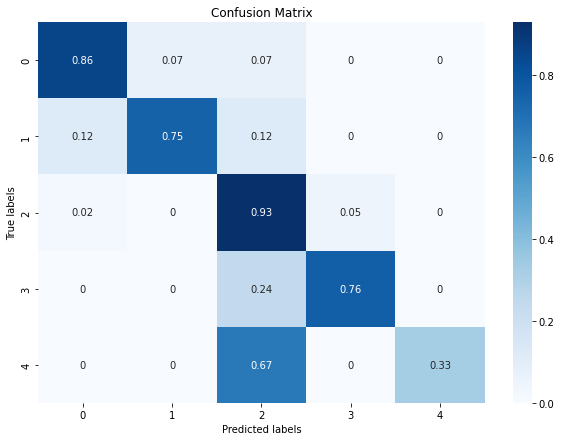

Micro-averaged One-vs-Rest ROC AUC score:
0.96


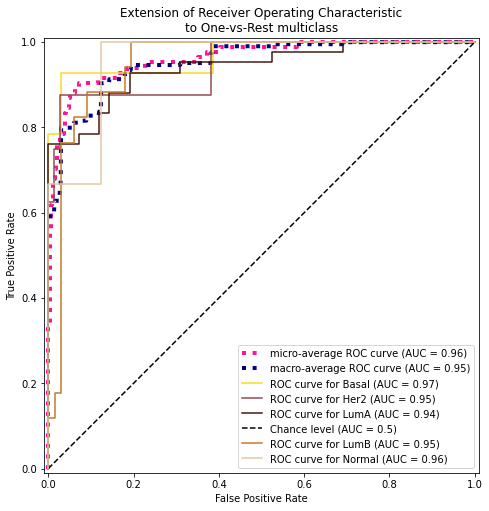

In [6]:
actuals, predictions = get_predictions(model.to('cpu'), test_loader)

cm = plot_confusion_matrix(actuals , predictions)

actuals, probs = get_probabilities(model.to('cpu'), test_loader)
# Assuming `probs` has been calculated as the probability outcomes for class 1, if not implement it
auc = roc_auc_score(actuals, probs , multi_class='ovr')

roc = plot_roc_curve(np.array(actuals), np.array(probs) , n_classes = 5 , target_names = datMeta['paper_BRCA_Subtype_PAM50'].astype('category').cat.categories)

In [7]:
non_zero_sum = 0
for param in model.parameters():
    non_zero_elements = (param != 0) # filter non-zero elements
    non_zero_sum += non_zero_elements.sum()  # sum them up

print("Sum of non-zero parameters:", non_zero_sum.item())

Sum of non-zero parameters: 22064133


### Functions for checking and clearing GPU memory if required

In [8]:
get_gpu_memory()
#del model , train_loader , test_loader
torch.cuda.reset_accumulated_memory_stats()
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory()

Total = 6.4Gb 	 Reserved = 0.6Gb 	 Allocated = 0.0Gb
Total = 6.4Gb 	 Reserved = 0.0Gb 	 Allocated = 0.0Gb


## Interpretability

In [9]:
from interpret import interpret , evaluate_interpret_save

Save Path Not Found - Plots will not be saved


C:\Users\Barry\anaconda3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\Barry\anaconda3\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


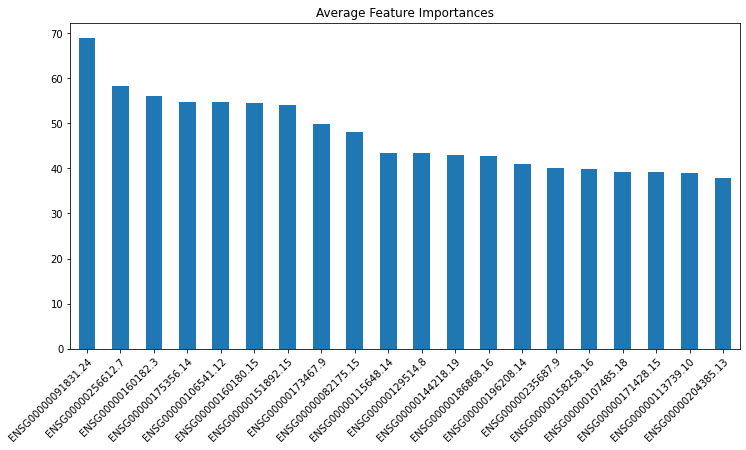

Linear(in_features=30459, out_features=723, bias=True)
MaskedLinear(in_features=723, out_features=1397, bias=True)
MaskedLinear(in_features=1397, out_features=1066, bias=True)
MaskedLinear(in_features=1066, out_features=447, bias=True)
MaskedLinear(in_features=447, out_features=147, bias=True)
MaskedLinear(in_features=147, out_features=26, bias=True)


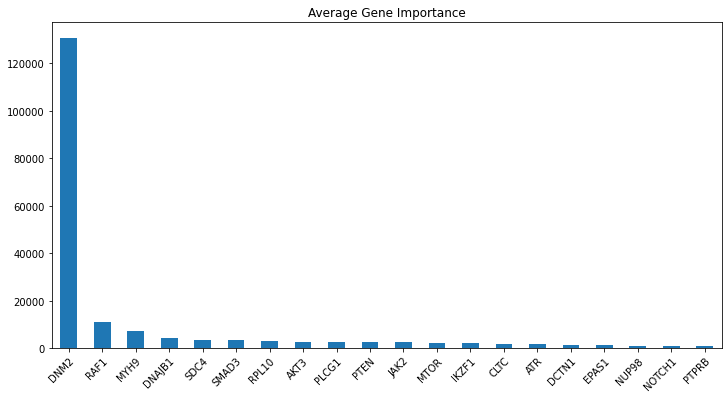

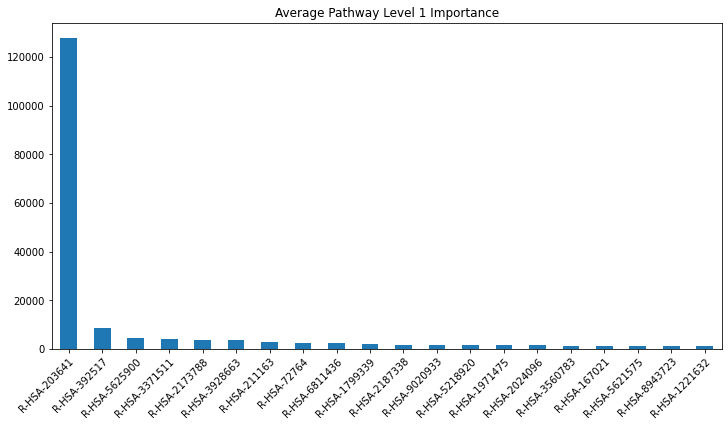

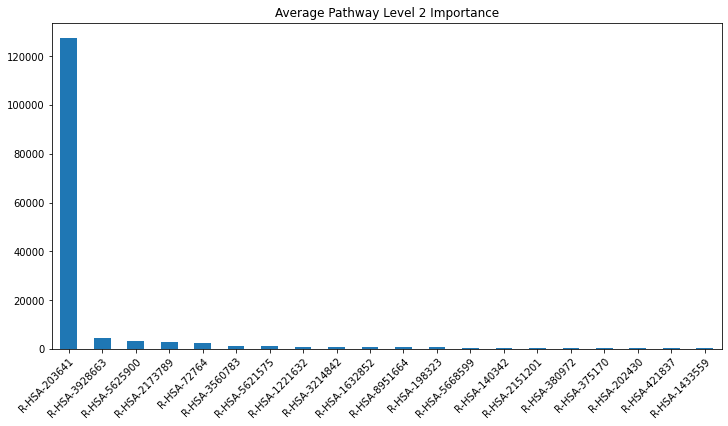

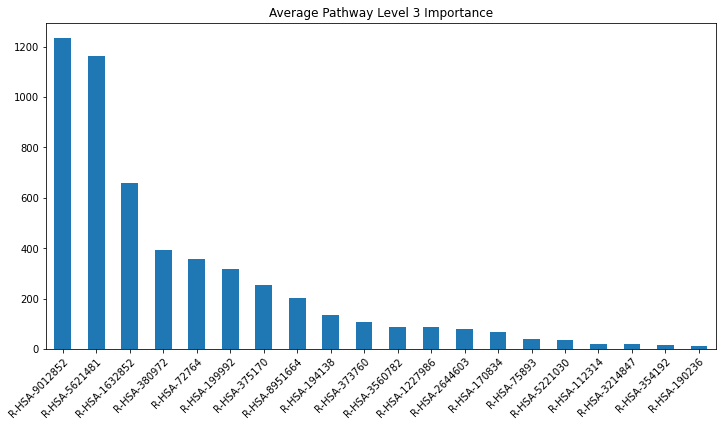

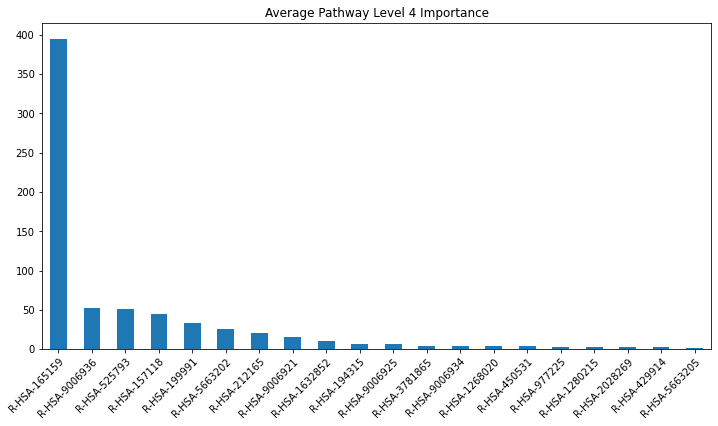

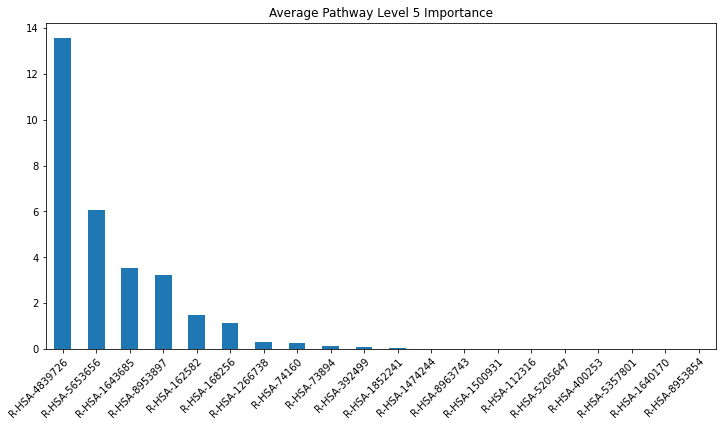

In [10]:
# Extract all data and targets using list comprehensions
data_batches, target_batches = zip(*[(data, target) for data, target in test_loader])

# Convert lists of batches into single tensors
test_data = torch.cat(data_batches, dim=0)
test_targets = torch.cat(target_batches , dim =0)

# Assign the model features to the columns
model.features = datExpr.columns

model_importances = interpret(model.eval() , test_data , savedir='None')

## Generate and Save Metrics + Importance

Single function to generate and save all model metrics and importances

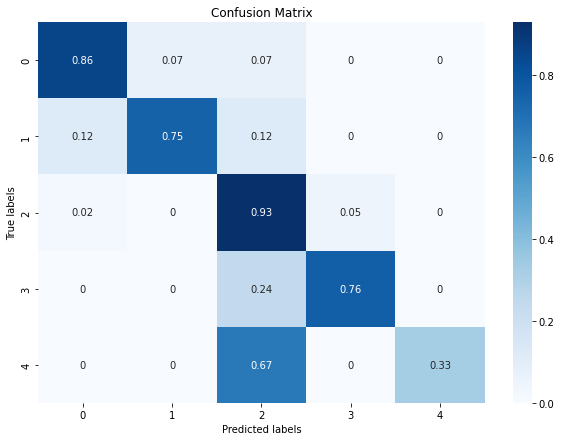

AUC Score: 0.9531787520124766
Micro-averaged One-vs-Rest ROC AUC score:
0.96


C:\Users\Barry\anaconda3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\Barry\anaconda3\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


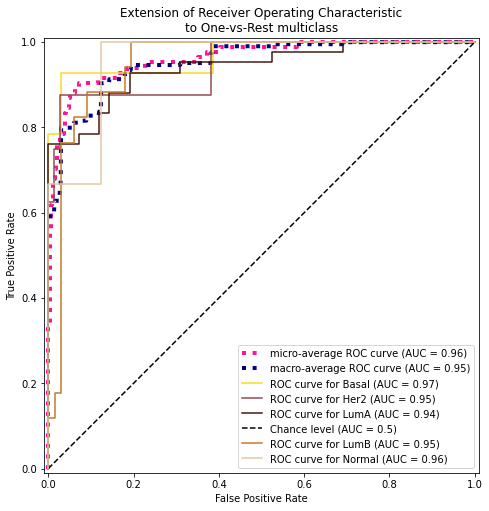

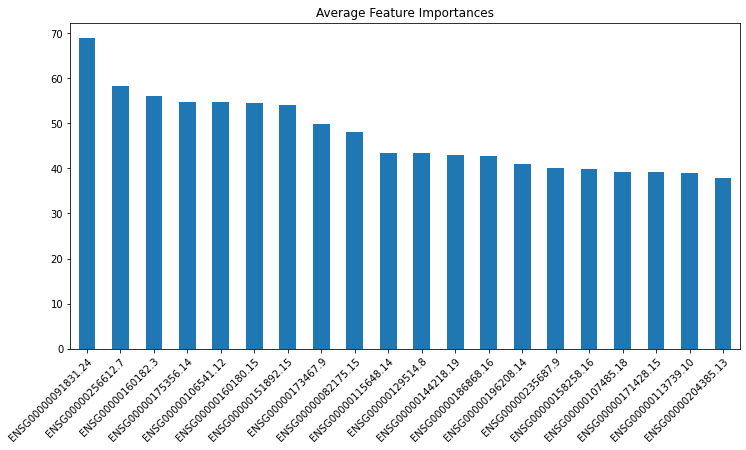

Linear(in_features=30459, out_features=723, bias=True)
MaskedLinear(in_features=723, out_features=1397, bias=True)
MaskedLinear(in_features=1397, out_features=1066, bias=True)
MaskedLinear(in_features=1066, out_features=447, bias=True)
MaskedLinear(in_features=447, out_features=147, bias=True)
MaskedLinear(in_features=147, out_features=26, bias=True)


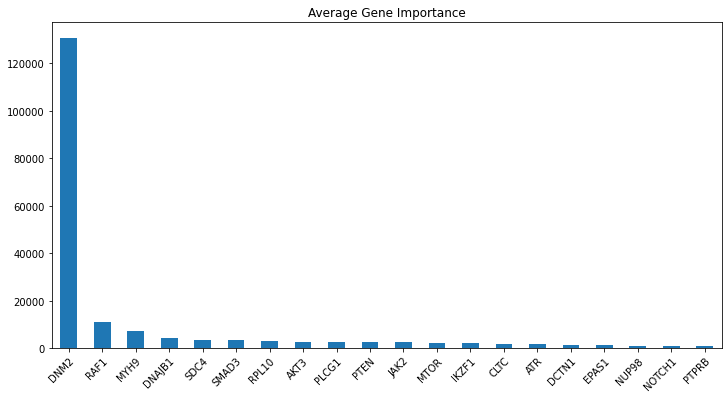

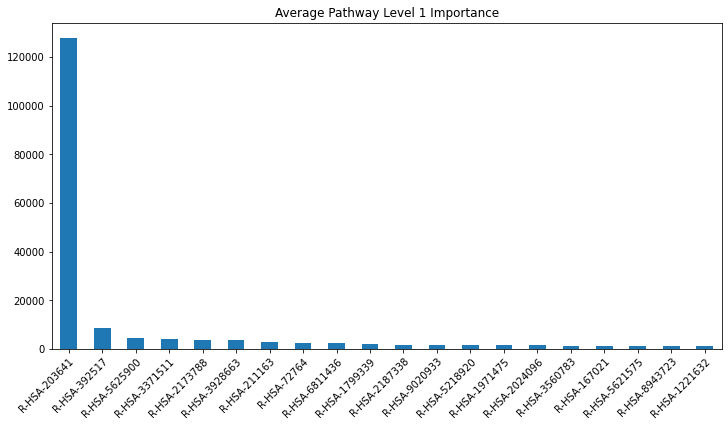

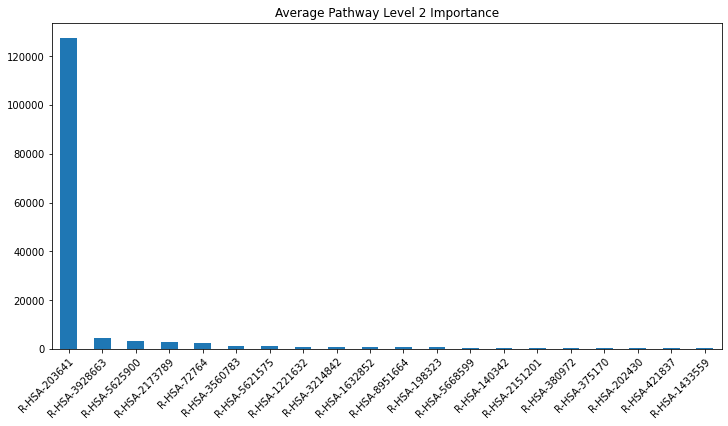

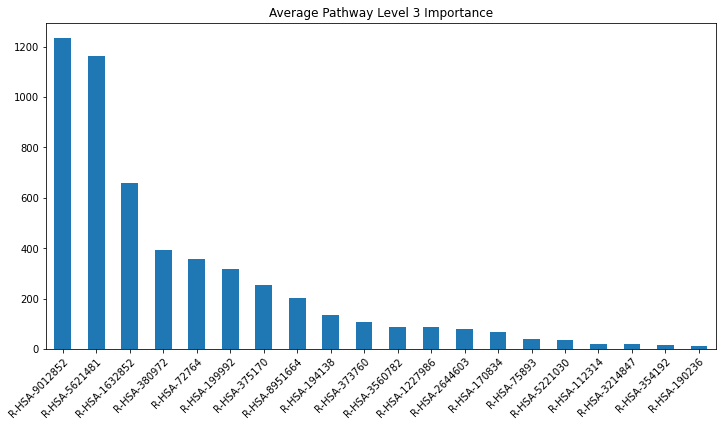

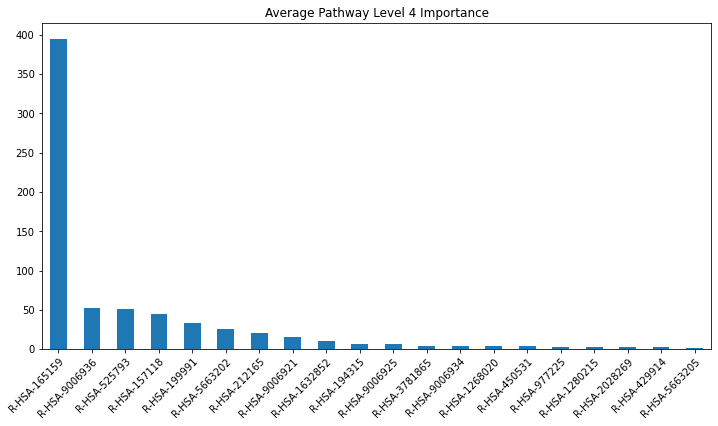

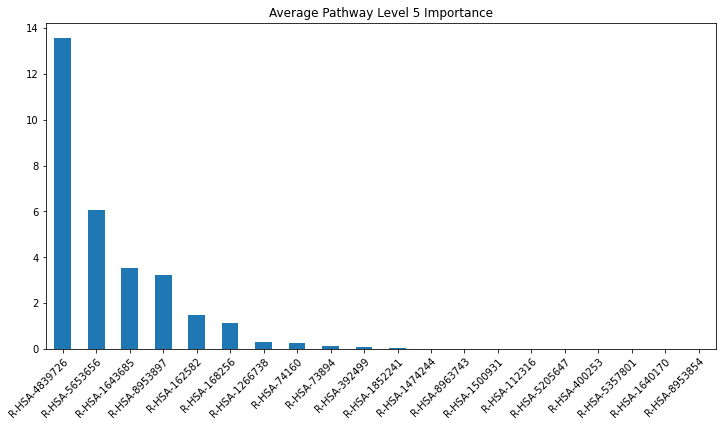

In [11]:
evaluate_interpret_save(model , test_loader , './Output/Prostate' , n_classes = 5 , target_names = datMeta['paper_BRCA_Subtype_PAM50'].astype('category').cat.categories)